In [1]:
import pandas as pd
import numpy as np


df = pd.read_parquet('./btc_hist_partitioned.parquet')

In [2]:
# MLFlow Configuration
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Bitcoin Price Prediction")

<Experiment: artifact_location='mlflow-artifacts:/318641207703663053', creation_time=1734299208848, experiment_id='318641207703663053', last_update_time=1734299208848, lifecycle_stage='active', name='Bitcoin Price Prediction', tags={}>

In [3]:
np.random.seed(42)

In [4]:
df.head()

,Date,Open,High,Low,Close,m_avg_7,m_avg_25,m_avg_99,close_diff,m_avg_7_diff,m_avg_25_diff,m_avg_99_diff
0,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3893.464722,3893.464722,3893.464722,0.025989,0.012995,0.012995,0.012995
1,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3874.556885,3874.556885,3874.556885,-0.027050,-0.004856,-0.004856,-0.004856
2,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3870.347046,3870.347046,3870.347046,0.005467,-0.001087,-0.001087,-0.001087
3,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3865.316553,3865.316553,3865.316553,-0.003246,-0.001300,-0.001300,-0.001300
4,2019-01-06,3836.519043,4093.297363,3826.513184,4076.632568,3900.535889,3900.535889,3900.535889,0.060189,0.009112,0.009112,0.009112


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## Ajuste da variável alvo

Nesta etapa ajusta-se a coluna de fechamento para que dados os dados de hoje, possamos prever o fechamento de amanhã.

In [6]:
df['Close'] = df['Close'].shift(-1)
df.isna().sum(), df.shape

(Open             0
 High             0
 Low              0
 Close            1
 m_avg_7          0
 m_avg_25         0
 m_avg_99         0
 close_diff       0
 m_avg_7_diff     0
 m_avg_25_diff    0
 m_avg_99_diff    0
 dtype: int64,
 (2150, 11))

In [7]:
df.dropna(inplace=True)
df.isna().sum(), df.shape

(Open             0
 High             0
 Low              0
 Close            0
 m_avg_7          0
 m_avg_25         0
 m_avg_99         0
 close_diff       0
 m_avg_7_diff     0
 m_avg_25_diff    0
 m_avg_99_diff    0
 dtype: int64,
 (2149, 11))

In [8]:
correlation = df.corr()

<Axes: >

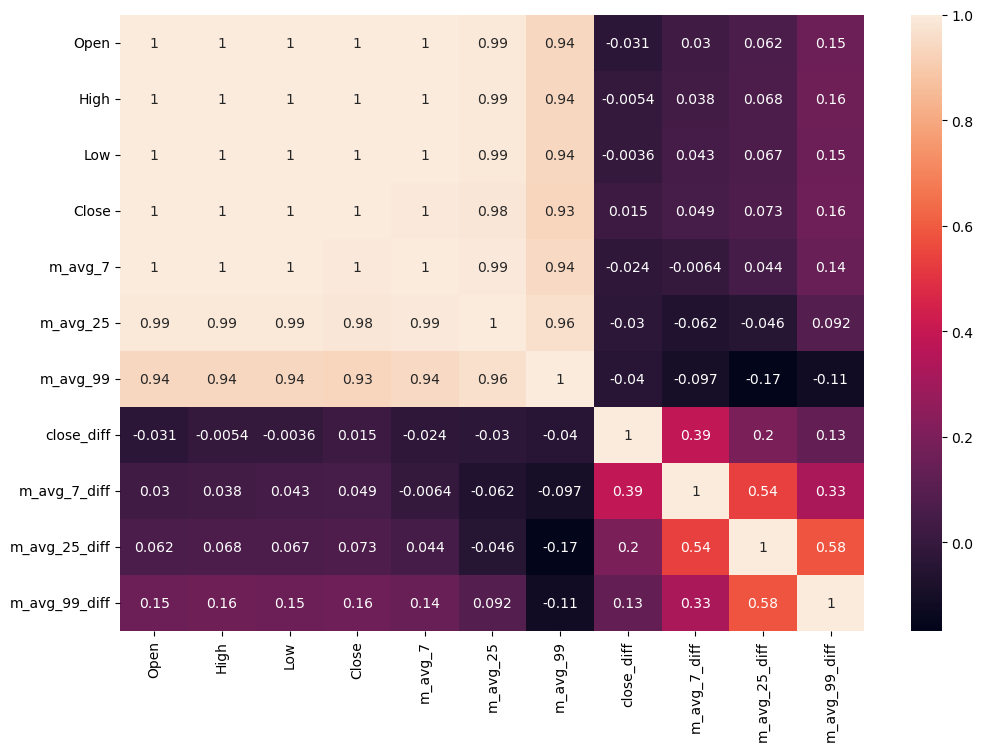

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True)

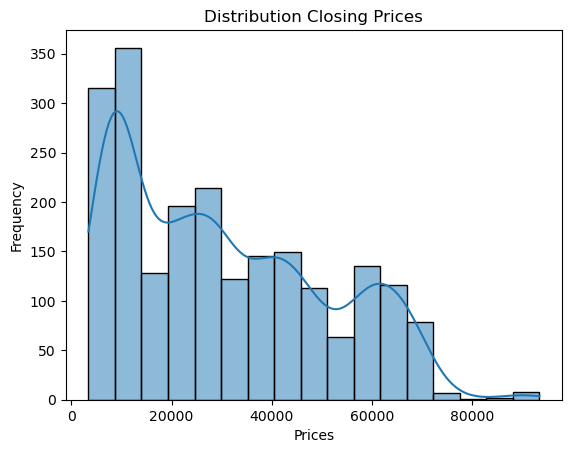

In [10]:
sns.histplot(df['Close'], kde=True)
plt.title('Distribution Closing Prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [11]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'm_avg_7', 'm_avg_25', 'm_avg_99',
       'close_diff', 'm_avg_7_diff', 'm_avg_25_diff', 'm_avg_99_diff'],
      dtype='object')

In [12]:
X = df.drop('Close', axis=1)
y = df['Close']

test_size = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)


In [13]:
def get_grid_search_metrics_and_model_regressor(estimator, param_grid, X_train, y_train, X_test, y_test, estimator_name='estimator', mlflow_model_name='model'):
  # Start an MLflow run
  with mlflow.start_run():
    kfold = KFold(n_splits=5, shuffle=True)
    steps = [('scaler', StandardScaler()), (estimator_name, estimator)]
    
    pipeline = Pipeline(steps=steps)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv=kfold, n_jobs=-1, refit='r2')

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    best_scores = {
        'r2_score': r2_score(y_test, y_pred),
        'mean_absolute_error': mean_absolute_error(y_test, y_pred),
        'mean_squared_error': mean_squared_error(y_test, y_pred),
        'root_mean_squared_error': root_mean_squared_error(y_test, y_pred)
    }

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("test_size", test_size)
    mlflow.log_metrics(best_scores)
    # for key, value in best_scores.items():
    #     mlflow.log_metric(key, value)

    mlflow.set_tag("Training Info", f"{mlflow_model_name} model for Bitcoin Price Prediction")
    signature = infer_signature(X_test, y_pred)

    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search.best_estimator_,
        artifact_path="bitcoin-price-prediction-model",
        signature=signature,
        input_example=X_train,
        registered_model_name=estimator_name,
    )

    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
    print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))
    print("Mean absolute error: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
    print("Root mean squared error: {:.2f}".format(root_mean_squared_error(y_test, y_pred)))
    return grid_search.best_estimator_, grid_search.best_params_, best_scores, model_info
  
    


In [14]:
def plot_predictions_versus_reality(y_test, y_pred, model_name='Model'):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

Successfully registered model 'rf_reg'.
2024/12/15 19:08:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rf_reg, version 1
Created version '1' of model 'rf_reg'.


Best parameters: {'rf_reg__criterion': 'poisson', 'rf_reg__max_depth': 8, 'rf_reg__min_samples_split': 4, 'rf_reg__n_estimators': 50}
Best cross-validation score: 0.99
Test set score: 0.63
R2 score: 0.63
Mean absolute error: 3616.98
Mean squared error: 35724147.54
Root mean squared error: 5976.97
🏃 View run rumbling-carp-571 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/05532cd1dadb4c4095bd352a078f9bb6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


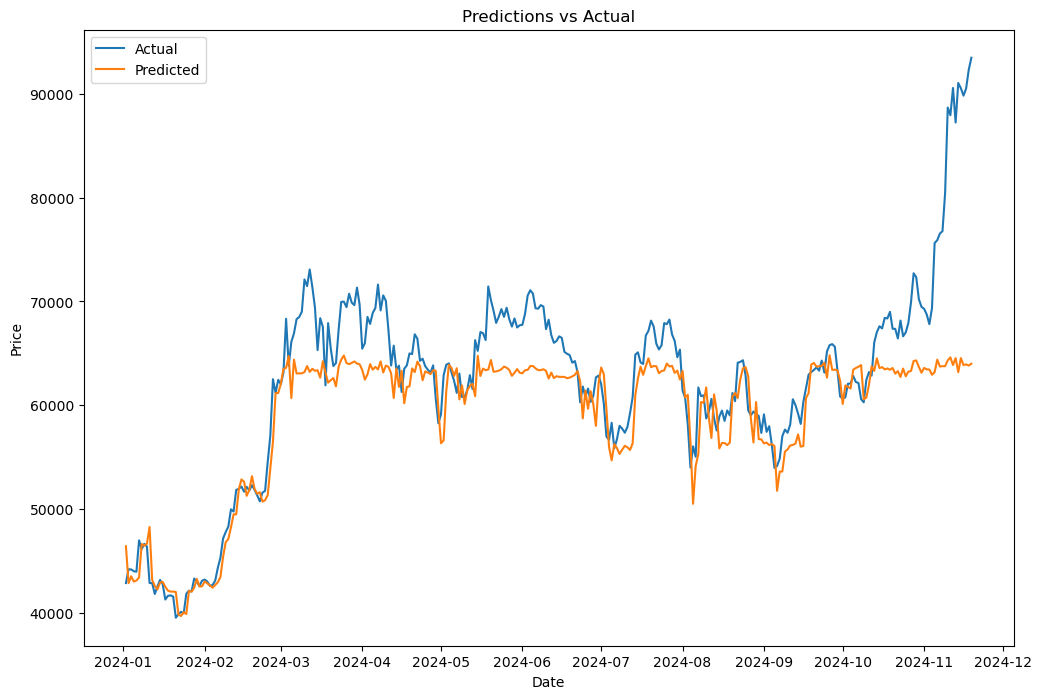

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_reg_param_grid = {
    "rf_reg__n_estimators": [25, 50, 100, 150],
    "rf_reg__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "rf_reg__max_depth": np.arange(3, 10),
    "rf_reg__min_samples_split": np.arange(2, 10),
}

model_name = "Random Forest Regressor"


model, params, score, model_info = get_grid_search_metrics_and_model_regressor(RandomForestRegressor(), rf_reg_param_grid, X_train, y_train, X_test, y_test, "rf_reg", mlflow_model_name=model_name)
y_pred = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_pred, model_name=model_name)

Successfully registered model 'lin_reg'.
2024/12/15 19:08:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lin_reg, version 1
Created version '1' of model 'lin_reg'.


Best parameters: {'lin_reg__fit_intercept': True, 'lin_reg__positive': True}
Best cross-validation score: 1.00
Test set score: 0.97
R2 score: 0.97
Mean absolute error: 1308.57
Mean squared error: 3322492.00
Root mean squared error: 1822.77
🏃 View run lyrical-ox-80 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/d4b9d020fe254f209c8258c912535923
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


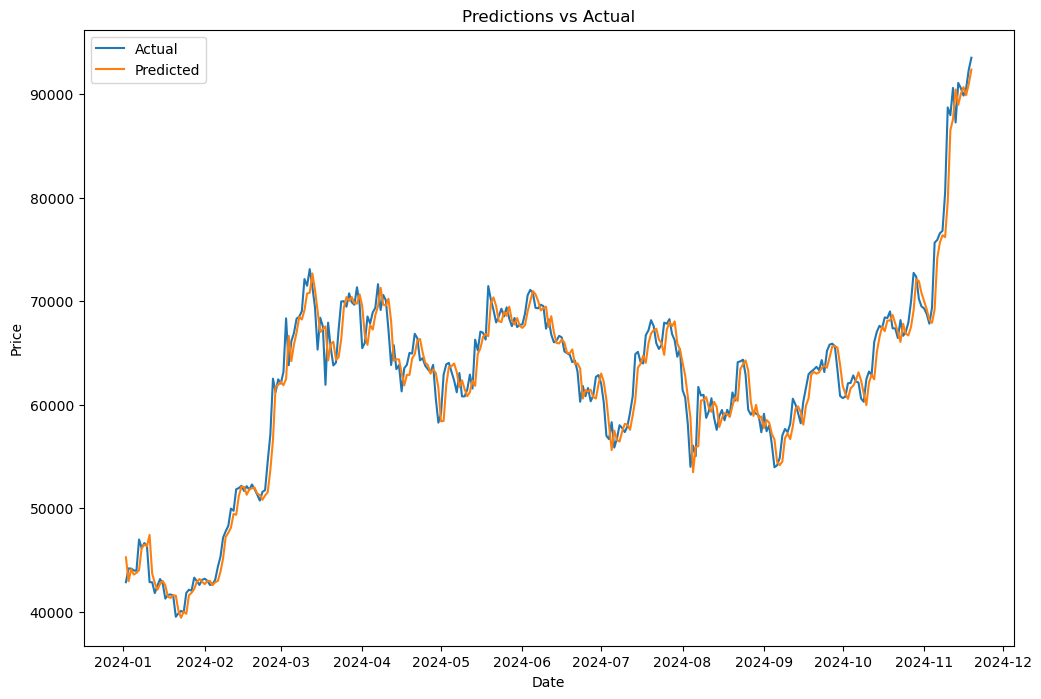

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg_param_grid={
    "lin_reg__fit_intercept": [True, False],
    "lin_reg__positive": [False, True]
}

model_name = "Linear Regression"

model, params, score, model_info = get_grid_search_metrics_and_model_regressor(LinearRegression(), lin_reg_param_grid, X_train, y_train, X_test, y_test, 'lin_reg', mlflow_model_name=model_name)

y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = c

Best parameters: {'en__alpha': 0.0, 'en__fit_intercept': True, 'en__l1_ratio': 0.4, 'en__positive': False, 'en__selection': 'random'}
Best cross-validation score: 1.00
Test set score: 0.97
R2 score: 0.97
Mean absolute error: 1308.84
Mean squared error: 3327691.30
Root mean squared error: 1824.20
🏃 View run lyrical-smelt-222 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/e89e1de16a09483abf5fe0155dd5a14b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


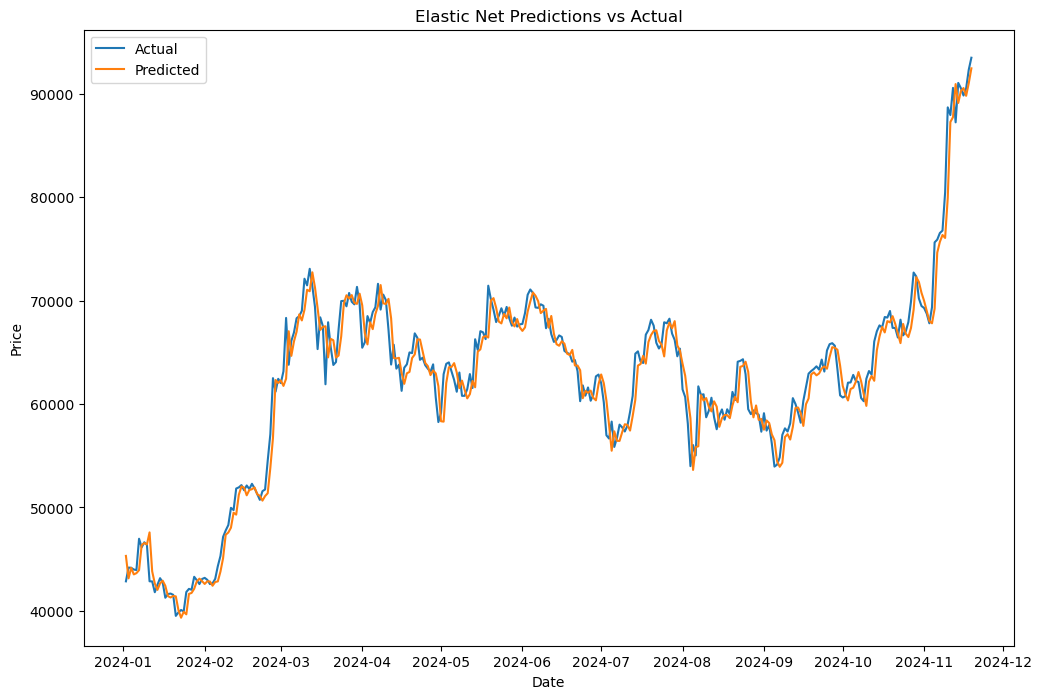

In [22]:
from sklearn.linear_model import ElasticNet
en_param_grid={
    "en__alpha": np.arange(0, 1, 0.1),
    "en__l1_ratio": np.arange(0, 1, 0.1),
    "en__fit_intercept": [True, False],
    "en__positive": [True, False],
    "en__selection": ['cyclic', 'random'],
}


model_name = "Elastic Net"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(ElasticNet(), en_param_grid, X_train, y_train, X_test, y_test, 'en', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Registered model 'kn_reg' already exists. Creating a new version of this model...
2024/12/15 19:13:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: kn_reg, version 2
Created version '2' of model 'kn_reg'.


Best parameters: {'kn_reg__algorithm': 'ball_tree', 'kn_reg__leaf_size': 15, 'kn_reg__n_neighbors': 8, 'kn_reg__weights': 'distance'}
Best cross-validation score: 0.99
Test set score: 0.53
R2 score: 0.53
Mean absolute error: 4756.44
Mean squared error: 44654438.85
Root mean squared error: 6682.40
🏃 View run salty-grub-703 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/1757c54f69fe47da85d67b84bbe4b7ae
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


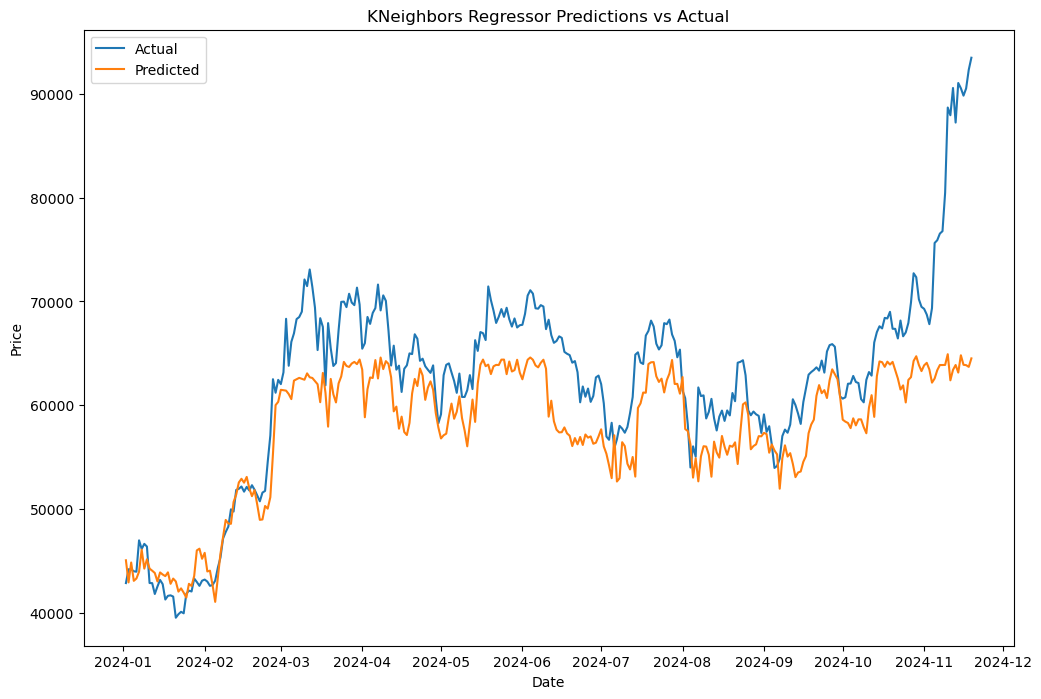

In [23]:
from sklearn.neighbors import KNeighborsRegressor

kn_reg_param_grid={
    "kn_reg__n_neighbors": range(2, 15),
    "kn_reg__leaf_size": range(15, 50),
    "kn_reg__weights": ['uniform', 'distance'],
    "kn_reg__algorithm": ['ball_tree', 'kd_tree'],
}

model_name = "KNeighbors Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(KNeighborsRegressor(), kn_reg_param_grid, X_train, y_train, X_test, y_test, 'kn_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

Successfully registered model 'ada_reg'.
2024/12/15 20:25:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ada_reg, version 1
Created version '1' of model 'ada_reg'.


Best parameters: {'ada_reg__learning_rate': 2.5, 'ada_reg__n_estimators': 100}
Best cross-validation score: 0.99
Test set score: 0.55
R2 score: 0.55
Mean absolute error: 4150.09
Mean squared error: 42989604.72
Root mean squared error: 6556.65
🏃 View run whimsical-ox-10 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/6ef1c0fdec2f42cbb90e102d9f96ae35
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


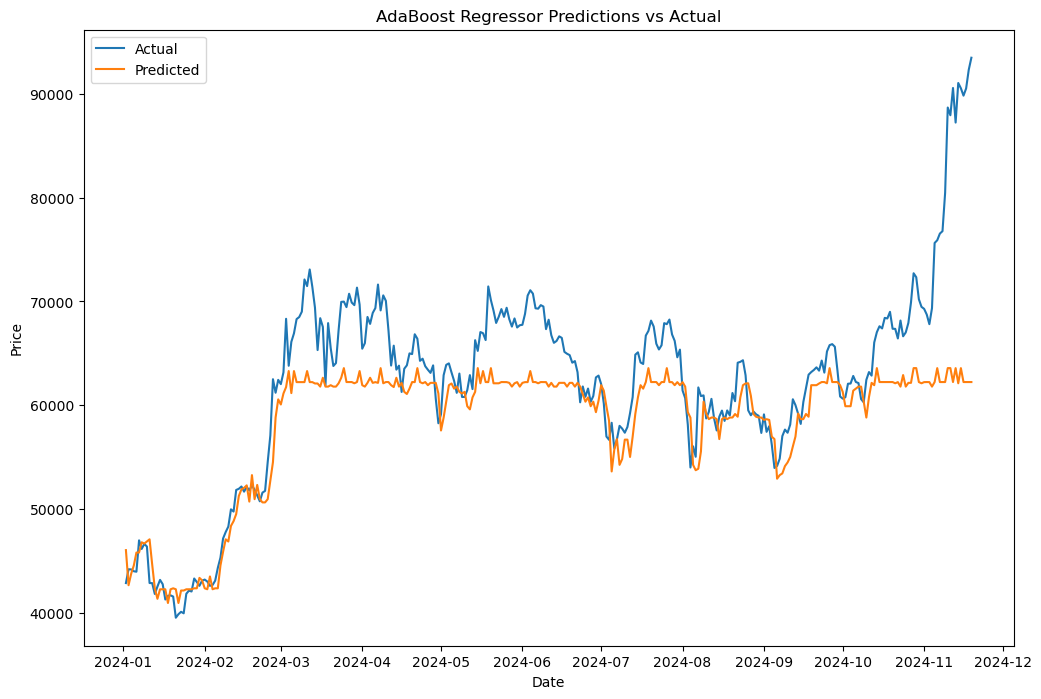

In [15]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg_param_grid = {
    "ada_reg__n_estimators": [25, 50, 100],
    "ada_reg__learning_rate": [0.1, 0.25, 0.5, 1, 1.5, 2.5, 5],
}

model_name = "AdaBoost Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(AdaBoostRegressor(), ada_reg_param_grid, X_train, y_train, X_test, y_test, 'ada_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

Successfully registered model 'gb_reg'.
2024/12/15 20:30:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gb_reg, version 1
Created version '1' of model 'gb_reg'.


Best parameters: {'gb_reg__learning_rate': 0.1, 'gb_reg__max_depth': 4, 'gb_reg__min_samples_split': 4, 'gb_reg__n_estimators': 100}
Best cross-validation score: 0.99
Test set score: 0.43
R2 score: 0.43
Mean absolute error: 4948.98
Mean squared error: 54534969.44
Root mean squared error: 7384.78
🏃 View run polite-panda-443 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/afd7f7a4c6344fe9b9652b46f7c9b456
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


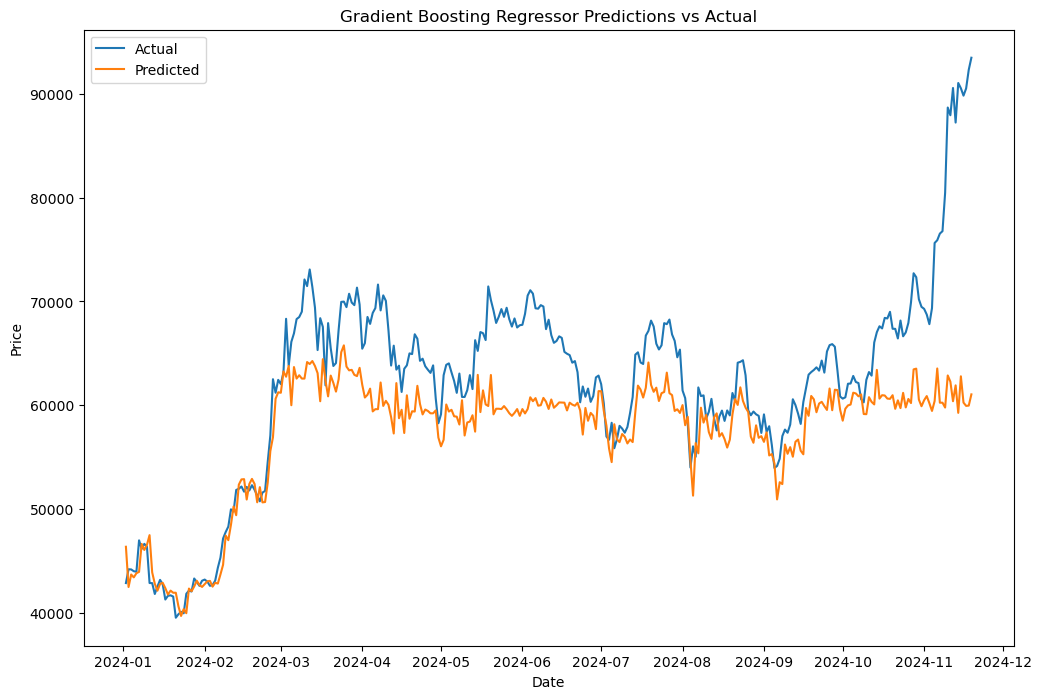

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg_param_grid = {
    "gb_reg__n_estimators": [25, 50, 100],
    "gb_reg__learning_rate": [0.1, 0.5, 1],
    "gb_reg__max_depth": np.arange(3, 10),
    "gb_reg__min_samples_split": np.arange(2, 10),
}

model_name = "Gradient Boosting Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(GradientBoostingRegressor(), gb_reg_param_grid, X_train, y_train, X_test, y_test, 'gb_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

Successfully registered model 'xgb_reg'.
2024/12/15 20:31:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_reg, version 1
Created version '1' of model 'xgb_reg'.


Best parameters: {'xgb_reg__learning_rate': 0.1, 'xgb_reg__max_depth': 3, 'xgb_reg__min_child_weight': 1, 'xgb_reg__n_estimators': 100}
Best cross-validation score: 0.99
Test set score: 0.56
R2 score: 0.56
Mean absolute error: 4121.25
Mean squared error: 42236661.41
Root mean squared error: 6498.97
🏃 View run gifted-ox-559 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/1572736b176f4c409b52b97cea334404
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


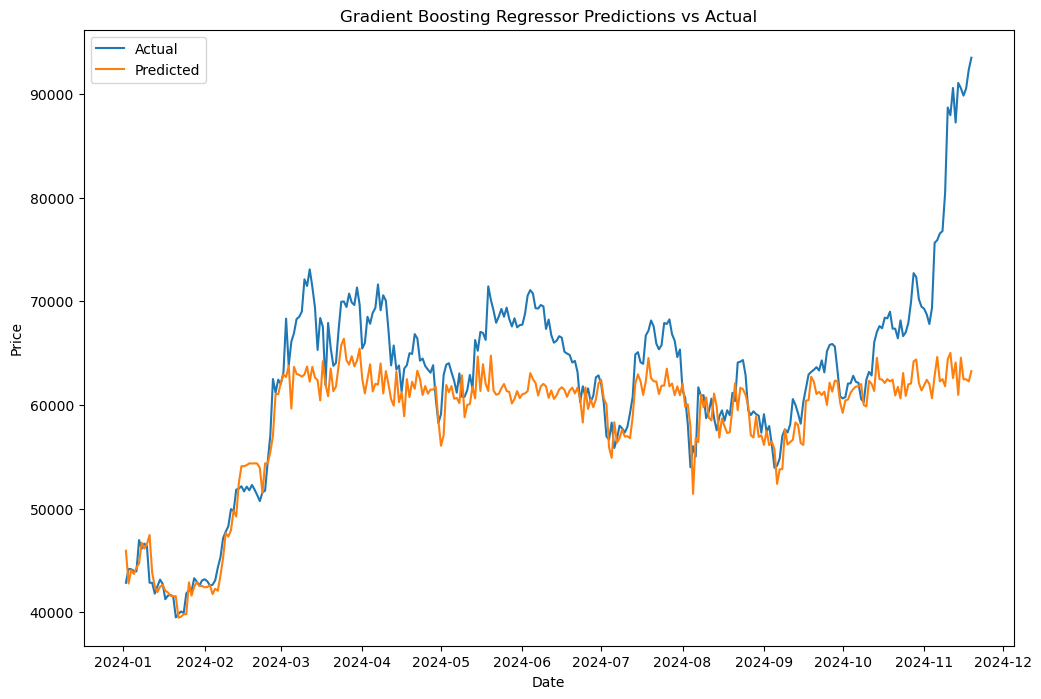

In [18]:
from xgboost import XGBRegressor

xgb_reg_param_grid = {
    "xgb_reg__n_estimators": [25, 50, 100],
    "xgb_reg__learning_rate": [0.1, 0.5, 1],
    "xgb_reg__max_depth": np.arange(3, 10),
    "xgb_reg__min_child_weight": np.arange(1, 10),
}

model_name = "Gradient Boosting Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(XGBRegressor(), xgb_reg_param_grid, X_train, y_train, X_test, y_test, 'xgb_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED

Best parameters: {'gamma_reg__alpha': 0.8, 'gamma_reg__fit_intercept': True, 'gamma_reg__solver': 'newton-cholesky'}
Best cross-validation score: 0.90
Test set score: -9.60
R2 score: -9.60
Mean absolute error: 25729.03
Mean squared error: 1012326514.05
Root mean squared error: 31817.08
🏃 View run placid-mink-810 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/4a14e8a720444db098a361a884c5d5b5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


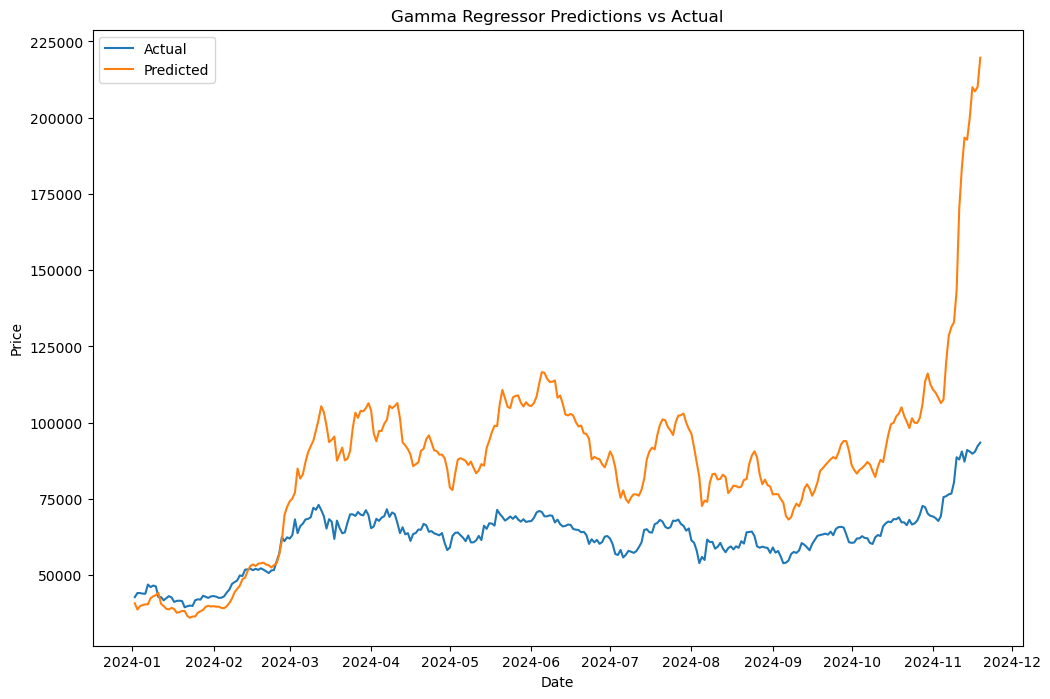

In [19]:
from sklearn.linear_model import GammaRegressor

gamma_reg_param_grid = {
    "gamma_reg__alpha": np.arange(0, 1, 0.2),
    "gamma_reg__fit_intercept": [True, False],
    "gamma_reg__solver": ['lbfgs', 'newton-cholesky'],
}

model_name = "Gamma Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(GammaRegressor(), gamma_reg_param_grid, X_train, y_train, X_test, y_test, 'gamma_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED

Best parameters: {'tweedie_reg__alpha': 0.0, 'tweedie_reg__fit_intercept': True, 'tweedie_reg__link': 'auto', 'tweedie_reg__power': 0, 'tweedie_reg__solver': 'newton-cholesky'}
Best cross-validation score: 1.00
Test set score: 0.97
R2 score: 0.97
Mean absolute error: 1306.74
Mean squared error: 3314214.85
Root mean squared error: 1820.50
🏃 View run respected-asp-751 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/d1dec8e5da3941bf9441145a3e69ecd5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053


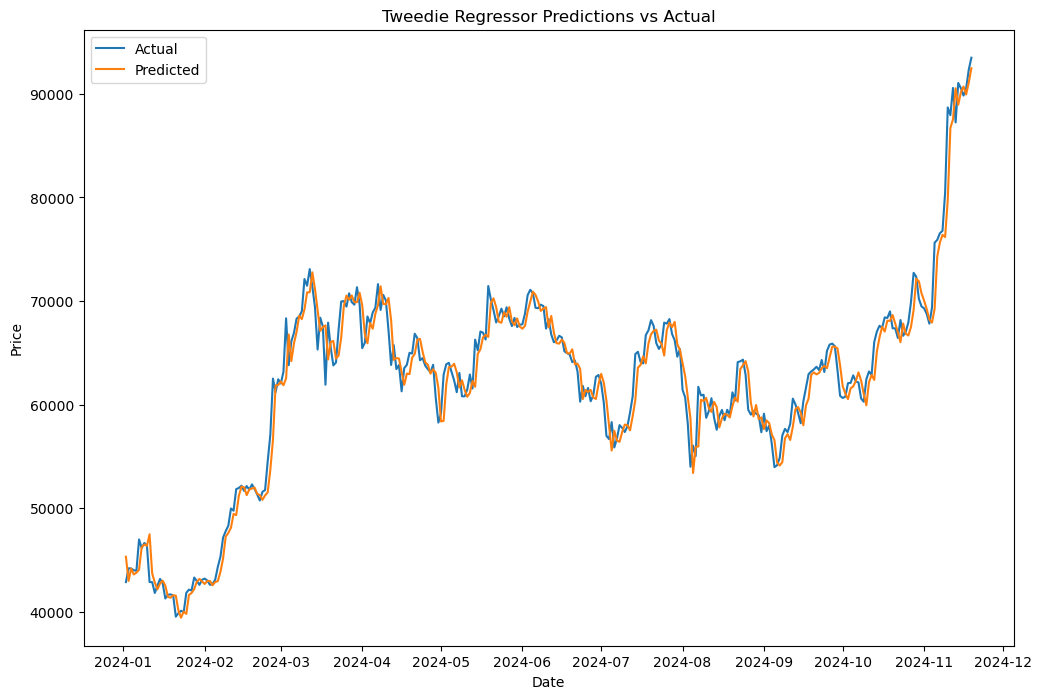

In [20]:
from sklearn.linear_model import TweedieRegressor

tweedie_reg_param_grid = {
    "tweedie_reg__power": np.arange(0, 4, 1),
    "tweedie_reg__alpha": np.arange(0, 1, 0.2),
    "tweedie_reg__fit_intercept": [True, False],
    "tweedie_reg__link": ['auto', 'identity', 'log'],
    "tweedie_reg__solver": ['lbfgs', 'newton-cholesky'],
}

model_name = "Tweedie Regressor"
model, params, score, model_info = get_grid_search_metrics_and_model_regressor(TweedieRegressor(), tweedie_reg_param_grid, X_train, y_train, X_test, y_test, 'tweedie_reg', mlflow_model_name=model_name)
y_hat = model.predict(X_test)
plot_predictions_versus_reality(y_test, y_hat, model_name=model_name)

In [36]:
from sklearn.linear_model import ARDRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

with mlflow.start_run():
    ard_poly = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        ARDRegression(),
    ).fit(X_train, y_train)

    y_ard, y_ard_std = ard_poly.predict(X_test, return_std=True)

    mlflow.log_params({
        "PolynomialFeatures__degree": 2,
        "PolynomialFeatures__include_bias": False,
    })

    mlflow.log_metrics({
        "R2 score": r2_score(y_test, y_ard),
        "Mean absolute error": mean_absolute_error(y_test, y_ard),
        "Mean squared error": mean_squared_error(y_test, y_ard),
        "Root mean squared error": np.sqrt(mean_squared_error(y_test, y_ard)),
    })

    mlflow.set_tag("Training Info", f"ARD Regression Model model for Bitcoin Price Prediction")
    signature = infer_signature(X_test, y_ard)

    model_info = mlflow.sklearn.log_model(
        sk_model=ard_poly,
        artifact_path="bitcoin-price-prediction-model",
        signature=signature,
        input_example=X_train,
        registered_model_name='ARDRegression',
    )

print("ARDRegression Metrics:")
print("R2 score: {:.2f}".format(r2_score(y_test, y_ard)))
print("Mean absolute error: {:.2f}".format(mean_absolute_error(y_test, y_ard)))
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_ard)))
print("Root mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_ard))))

Successfully registered model 'ARDRegression'.
2024/12/15 21:37:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ARDRegression, version 1
Created version '1' of model 'ARDRegression'.


🏃 View run handsome-chimp-978 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/344d9d5ef5da4d4aa0518f686b05c551
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053
ARDRegression Metrics:
R2 score: 0.96
Mean absolute error: 1368.15
Mean squared error: 3644538.25
Root mean squared error: 1909.07


In [37]:
from sklearn.linear_model import BayesianRidge

with mlflow.start_run():
    brr_poly = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        BayesianRidge(),
    ).fit(X_train, y_train)

    y_brr, y_brr_std = brr_poly.predict(X_test, return_std=True)

    mlflow.log_params({
        "PolynomialFeatures__degree": 2,
        "PolynomialFeatures__include_bias": False,
    })

    mlflow.log_metrics({
        "R2 score": r2_score(y_test, y_brr),
        "Mean absolute error": mean_absolute_error(y_test, y_brr),
        "Mean squared error": mean_squared_error(y_test, y_brr),
        "Root mean squared error": np.sqrt(mean_squared_error(y_test, y_brr)),
    })

    mlflow.set_tag("Training Info", f"BayesianRidge Model model for Bitcoin Price Prediction")
    signature = infer_signature(X_test, y_brr)

    model_info = mlflow.sklearn.log_model(
        sk_model=ard_poly,
        artifact_path="bitcoin-price-prediction-model",
        signature=signature,
        input_example=X_train,
        registered_model_name='BayesianRidgeRegression',
    )

print("BayesianRidge Regression Metrics:")
print("R2 score: {:.2f}".format(r2_score(y_test, y_brr)))
print("Mean absolute error: {:.2f}".format(mean_absolute_error(y_test, y_brr)))
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_brr)))
print("Root mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_brr))))




Successfully registered model 'BayesianRidgeRegression'.
2024/12/15 21:37:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BayesianRidgeRegression, version 1
Created version '1' of model 'BayesianRidgeRegression'.


🏃 View run stylish-bird-849 at: http://127.0.0.1:8080/#/experiments/318641207703663053/runs/755bf84394824ef6b5e84617202071ac
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318641207703663053
BayesianRidge Regression Metrics:
R2 score: 0.96
Mean absolute error: 1394.15
Mean squared error: 3779099.86
Root mean squared error: 1943.99
